## 20 News Group - 다중 분류

In [1]:
from sklearn.datasets import fetch_20newsgroups # fetch는 최초 한번은 PC에 다운받아야함
news = fetch_20newsgroups()

- 데이터 탐색

In [3]:
print(news.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [4]:
from pprint import pprint
pprint(news.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [5]:
import numpy as np
np.unique(news.target, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591,
        594, 593, 599, 546, 564, 465, 377], dtype=int64))

- 데이터셋 추출

In [6]:
train_news = fetch_20newsgroups(
    subset='train', random_state=2023, remove=('headers', 'quotes', 'footers')
#headers: 주소/quotes: 내가 아니라 다른사람이 쓴 글을 인용한 댓글/ footers: 가장 밑에 달린 글(작성자이든... 기타 등등)
)
X_train = train_news.data
y_train = train_news.target

In [7]:
test_news = fetch_20newsgroups(
    subset='test', random_state=2023, remove=('headers', 'quotes', 'footers')
)
X_test = test_news.data
y_test = test_news.target

In [8]:
len(X_train), len(X_test)

(11314, 7532)

- Feature 변환

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cvect = CountVectorizer(stop_words='english')
tvect = TfidfVectorizer(stop_words='english')

In [11]:
cvect.fit(X_train)
X_train_cv = cvect.transform(X_train)
X_test_cv = cvect.transform(X_test)
X_train_cv.shape, X_test_cv.shape

#X_train_cv.shape, X_test_cv.shape의 텍스트 사이즈가 동일

((11314, 101322), (7532, 101322))

In [12]:
tvect.fit(X_train)
X_train_tv = tvect.transform(X_train)
X_test_tv = tvect.transform(X_test)
X_train_tv.shape, X_test_tv.shape

((11314, 101322), (7532, 101322))

- 나이브 베이즈 분류기로 학습/평가

In [13]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [14]:
# Count Vectorizer + Naive Bayes
nb.fit(X_train_cv, y_train)
nb.score(X_test_cv, y_test)

0.6343600637280935

In [16]:
# Tfidf Vectorizer + Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tv, y_train)
nb.score(X_test_tv, y_test)


0.6779075942644716

In [17]:
# 비교
# 수행시간: NB: 0.1초, LR: 54.6초
# 정확도: MB: 0.6779, LR: 0.6909
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(random_state=2023, max_iter=500)
lrc.fit(X_train_tv, y_train)
lrc.score(X_test_tv, y_test)

0.6909187466808284

- Pipeline + GridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [26]:
pipeline = Pipeline([
    ('TVECT', TfidfVectorizer(stop_words='english')),
    ('NB', MultinomialNB())
])
params = {'TVECT__max_df':[300, 700], 'TVECT__ngram_range':[(1,1), (1,2)]}
grid_pipe = GridSearchCV(pipeline, params, scoring='accuracy', cv=3, n_jobs=-1)
%time grid_pipe.fit(X_train, y_train)
# 변수가 오지 않고 객체를 안에 넣어줘도 됨 
# 대신 리스트 안에 튜플형태로 넣어줘야함
# n_jobs=-1: 작업속도 빠르게!!

CPU times: total: 2.78 s
Wall time: 16.2 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('TVECT',
                                        TfidfVectorizer(stop_words='english')),
                                       ('NB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'TVECT__max_df': [300, 700],
                         'TVECT__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [27]:
grid_pipe.best_params_

{'TVECT__max_df': 300, 'TVECT__ngram_range': (1, 1)}

In [28]:
grid_pipe.best_estimator_.score(X_test, y_test)

0.6868029739776952

300개이하인 데이터만 돌려서 괜찮은 결과가 나온 것임
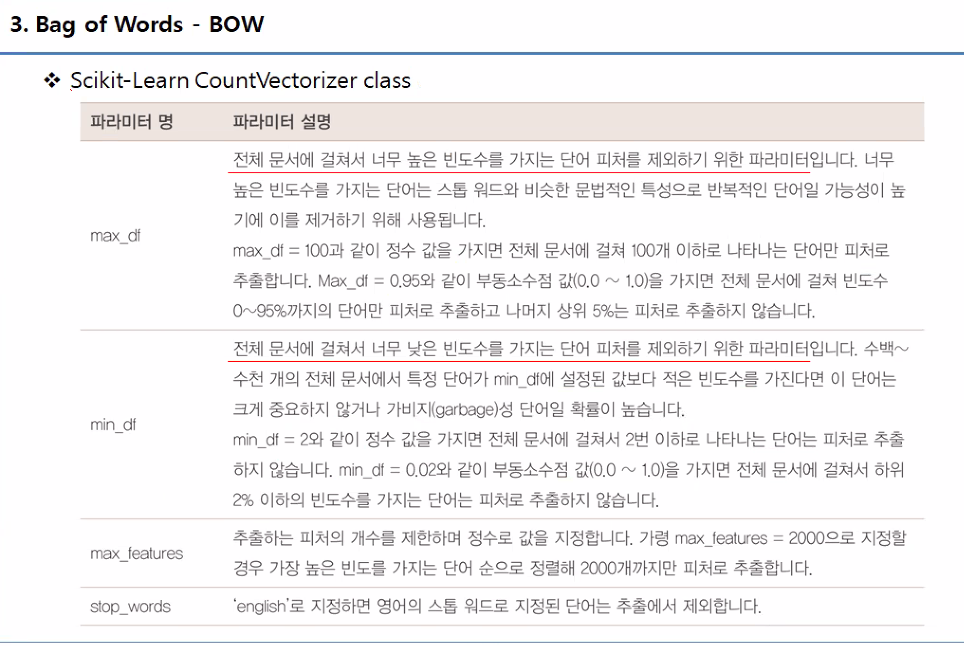

In [29]:
pipeline = Pipeline([
    ('TVECT', TfidfVectorizer(stop_words='english')),
    ('NB', MultinomialNB())         # 나이나 베이지가 속도가 빨라서 이용한것, 다른거 이용해도됨
])
params = {'TVECT__max_df': [200, 300, 400]}
grid_pipe = GridSearchCV(pipeline, params, scoring='accuracy', cv=3, n_jobs=-1)
%time grid_pipe.fit(X_train, y_train)

CPU times: total: 2.61 s
Wall time: 8.57 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('TVECT',
                                        TfidfVectorizer(stop_words='english')),
                                       ('NB', MultinomialNB())]),
             n_jobs=-1, param_grid={'TVECT__max_df': [200, 300, 400]},
             scoring='accuracy')

In [24]:
grid_pipe.best_params_

{'TVECT__max_df': 200}

In [25]:
grid_pipe.best_estimator_.score(X_test, y_test)

0.6816250663834307